

## Abstract:

Within the domain of salary prediction, this study investigates a dataset aimed at forecasting individuals' income levels. The dataset comprises a diverse set of features, including both numerical and categorical variables, providing a comprehensive overview of each individual's professional and demographic profile.

**Numerical features** such as 'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', and 'hours-per-week' offer quantifiable insights into factors potentially influencing salary outcomes. Meanwhile, categorical features like 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', and 'native-country' provide qualitative data essential for understanding the context of each individual's employment situation.

**The target variable**, 'salary', serves as the focal point, representing the income level of each individual. This endpoint is crucial for predicting salary ranges accurately, guiding decisions related to financial planning and resource allocation.

The methodology employed in this study involves fitting various machine learning models to the dataset to predict salary outcomes. Firstly, a linear model is fitted to interpret regression coefficients, revealing the direct influence of predictors on salary levels in a quantifiable manner. Subsequently, a tree-based model is explored to understand decision-making through the interpretation of decision nodes, highlighting the importance of specific features in predicting salary outcomes.

Moreover, AutoML techniques are utilized to streamline the process of model selection, automating the comparison of different models and configurations to identify the most effective one without manual intervention. Finally, SHAP (SHapley Additive exPlanations) analysis is applied to the models from previous steps, offering a granular breakdown of each feature's contribution to individual salary predictions. By interpreting SHAP values, insights into the drivers of salary predictions are obtained, facilitating a comparison of model interpretability across different methodologies.

Throughout this assignment, the emphasis is not only on building predictive models but also on deeply understanding them. This underscores the significance of transparency and ethical considerations in AI, ensuring that models are interpretable, fair, and accountable in the context of salary prediction.

## What is SHAP?

* SHAP stands for Shapley Additive explanations. In short, it's a tool that helps crack open the "black box" of machine learning models and see how different factors influence the model's decisions.

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.5 MB/s eta 0:00:00


In [4]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import shap

In [6]:
# Reading the dataset
data = pd.read_csv("https://raw.githubusercontent.com/thoratmansi/ModelInterpretability/main/salary.csv")

In [7]:
# Viewing data in the file
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [9]:
# Split data into features and target variable
X = data.drop(columns=['salary'])
y = data['salary']

In [10]:
import pandas as pd

# Count the number of NaNs in each column
nan_counts = data.isna().sum()

# Print the count of NaNs for each column
print(nan_counts)

# To only display columns that contain NaNs:
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64
Series([], dtype: int64)


In [11]:
data.corr()

<ipython-input-11-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

**Converting the non numeric data into numeric form**

In [13]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_columns = ['workclass','occupation','race','sex','native-country','relationship','education','marital-status']
encoder = OrdinalEncoder(categories='auto')
data[ordinal_columns] = encoder.fit_transform(data[ordinal_columns])

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['salary'] = le.fit_transform(data['salary'])

In [15]:
# independent variables are useful to predict a target
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['salary'].sort_values(ascending=False)
print(correlation_with_target)

salary            1.000000
education-num     0.335154
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
sex               0.215980
capital-loss      0.150526
education         0.079317
occupation        0.075468
race              0.071846
workclass         0.051604
native-country    0.015840
fnlwgt           -0.009463
marital-status   -0.199307
relationship     -0.250918
Name: salary, dtype: float64


<Axes: >

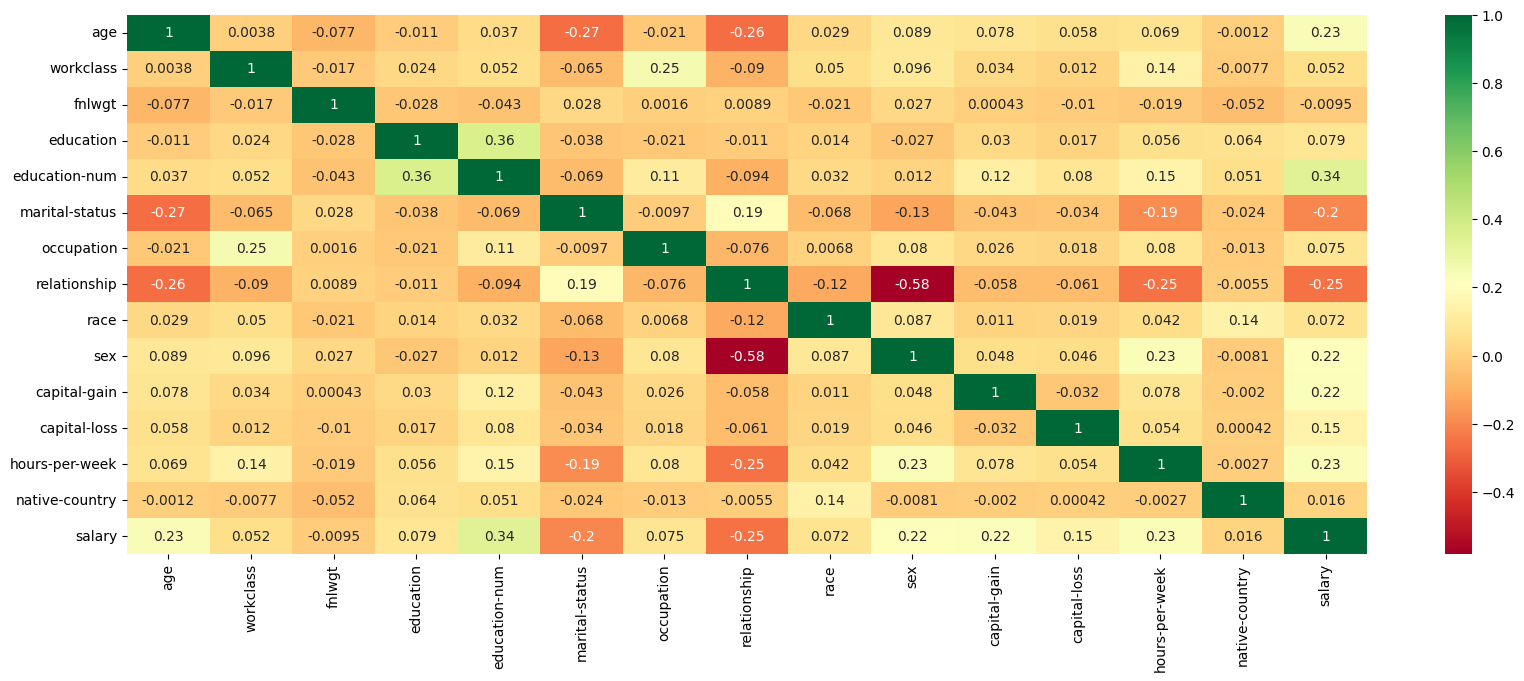

In [16]:
# the heat map of the correlation
plt.figure(figsize=(20, 7))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")

In [19]:
# Viewing data
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7.0,77516,9.0,13,4.0,1.0,1.0,4.0,1.0,2174,0,40,39.0,0
1,50,6.0,83311,9.0,13,2.0,4.0,0.0,4.0,1.0,0,0,13,39.0,0
2,38,4.0,215646,11.0,9,0.0,6.0,1.0,4.0,1.0,0,0,40,39.0,0
3,53,4.0,234721,1.0,7,2.0,6.0,0.0,2.0,1.0,0,0,40,39.0,0
4,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,5.0,0


In [26]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


### 1. Fit a linear model and interpret the regression coefficients


## Fitting a linear model

In [21]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming salary is your target variable
X = data.drop('salary', axis=1)
y = data['salary']

# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Interpret regression coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
print(coefficients)

           Feature   Coefficient
0              age  4.727651e-03
1        workclass -3.579119e-03
2           fnlwgt  6.717246e-08
3        education -3.670144e-03
4    education-num  4.712298e-02
5   marital-status -2.387951e-02
6       occupation  2.130028e-03
7     relationship -1.532038e-02
8             race  1.476682e-02
9              sex  1.035150e-01
10    capital-gain  9.272105e-06
11    capital-loss  1.135009e-04
12  hours-per-week  3.580916e-03
13  native-country -6.621888e-06


* Linear regression coefficients represent the change in the target variable for a one-unit change in the predictor variable, holding all other variables constant. Positive coefficients indicate a positive relationship, negative coefficients indicate a negative relationship, and the magnitude of the coefficient indicates the strength of the relationship.



In [40]:
shap.initjs()

In [42]:
explainer = shap.Explainer(linear_model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 3258it [04:22, 12.41it/s]


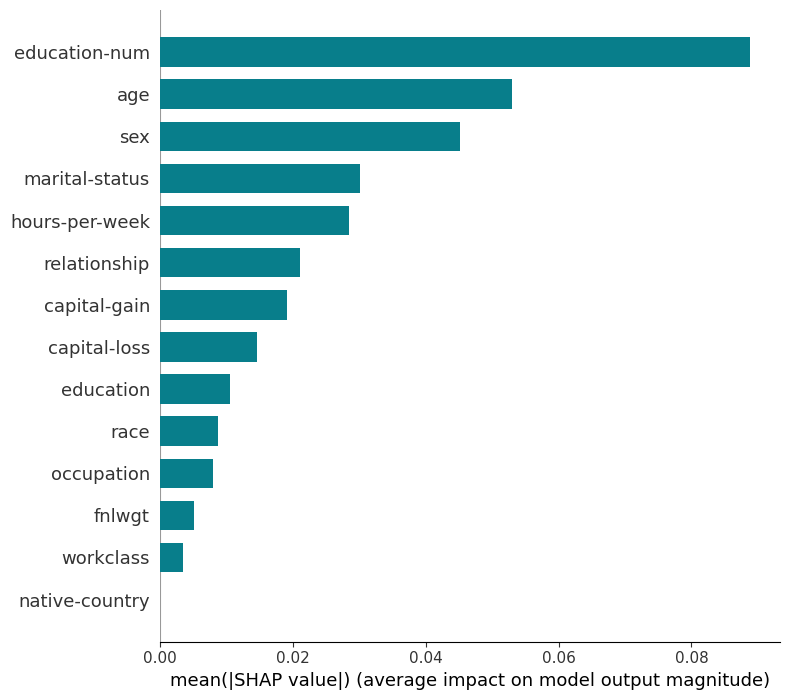

In [43]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

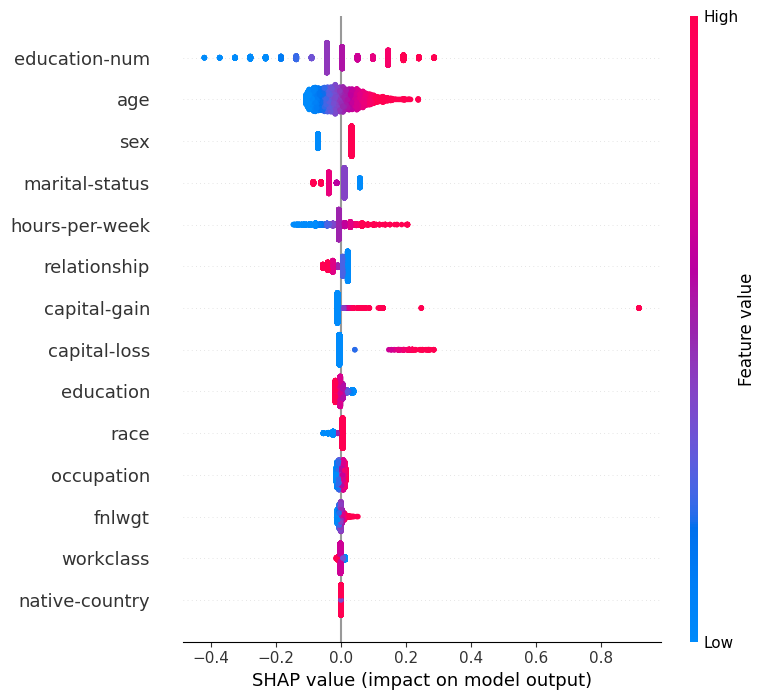

In [44]:
shap.summary_plot(shap_values, X_test)

* The SHAP force plot visualizes the impact of various features on a model's output, with red indicating a positive impact and blue indicating a negative impact.

* The output values are summarized by the SHAP force plot, which shows how much each feature (listed on the left) impacts the model's output (represented by the y-axis). The color of the dot on the force plot indicates the direction of the impact (red for positive, blue for negative), and the position on the x-axis shows the feature value. For instance, a red dot to the right for "education-num" means a higher number of years of education likely increases the model's output.  In this specific case, "capital-gain" has the greatest positive impact on the model's output, while "fnlwgt" has the least impact.

### 2. Fit a tree-based model and interpret the nodes

## TREE_BASED MODEL

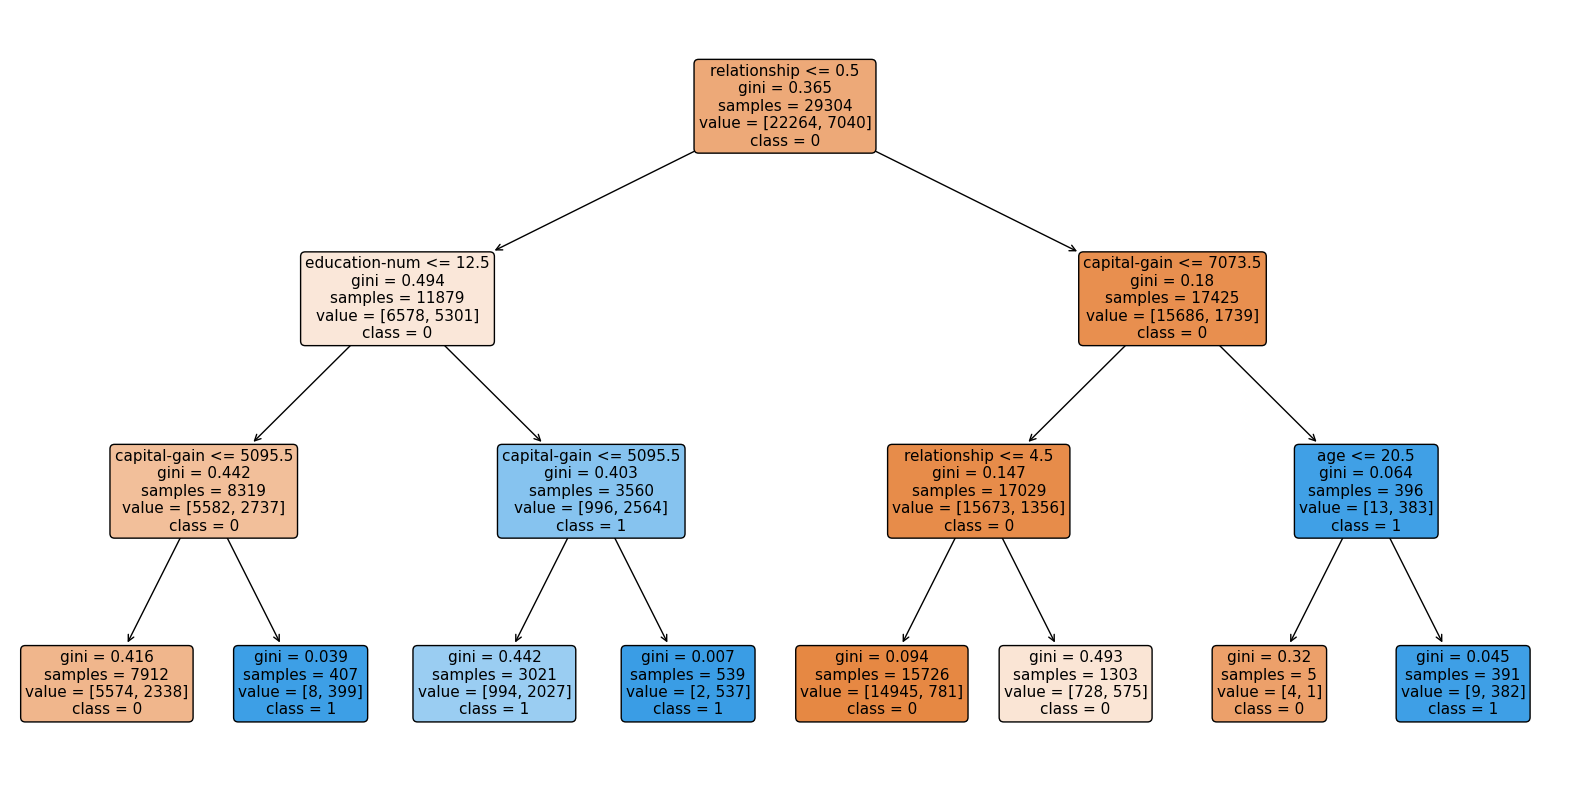

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Fit the decision tree model
tree_model = DecisionTreeClassifier(random_state=42, max_depth=3)
tree_model.fit(X_train, y_train)

# Convert integer class labels to strings
class_names = [str(label) for label in tree_model.classes_]

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=class_names, filled=True, rounded=True)
plt.show()


* SHAP values help understand how the model makes decisions by explaining the impact of different features on the model's output.

* Imagine the model predicts whether someone will get a loan.
* Features are like factors the model considers, such as years of education and income.
* The force plot shows how each feature impacts the model's prediction for a single person.
* A red dot means the feature increases the chance of getting a loan (e.g., more years of education).
* A blue dot means the feature decreases the chance (e.g., lower income).
* The further right the dot, the stronger the impact.
* In the specific image, "capital-gain" has the strongest positive impact, while "fnlwgt" has the least impact on the model's output.

In [45]:
shap.initjs()

In [46]:
explainer = shap.Explainer(tree_model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 3258it [02:53, 18.38it/s]                          


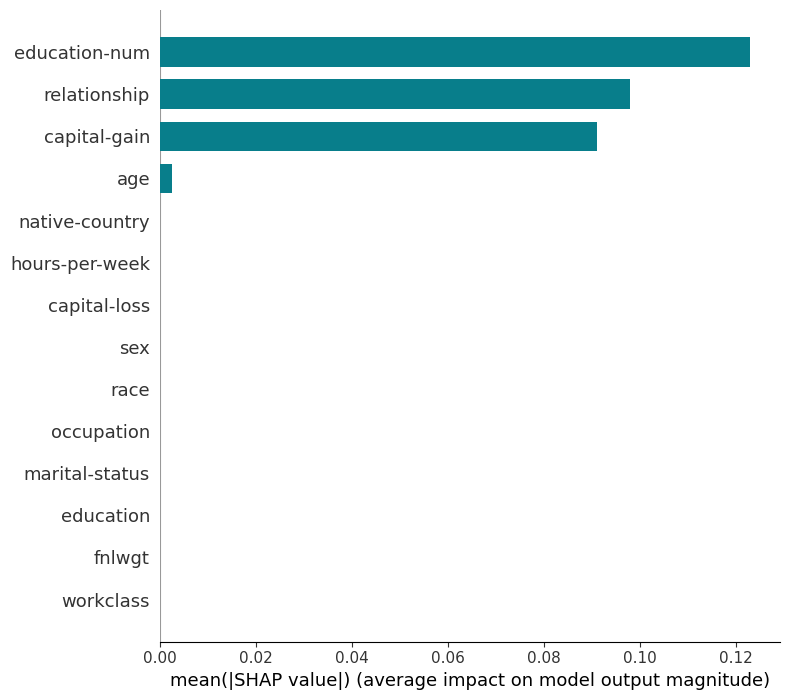

In [47]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

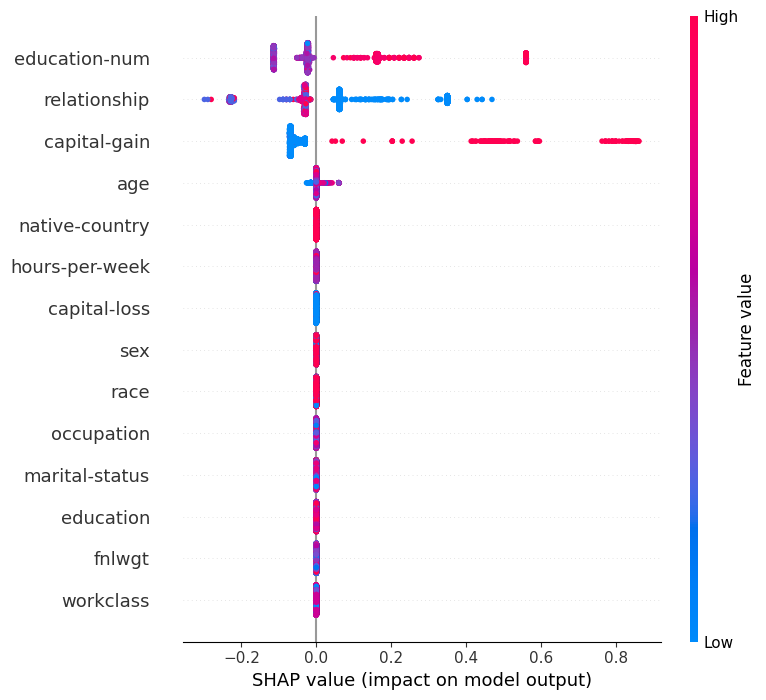

In [48]:
shap.summary_plot(shap_values, X_test)

* The SHAP force plot visualizes the impact of different features (listed on the left) on a machine learning model's output, with red indicating a positive impact and blue indicating a negative impact.

* The output values are summarized by the SHAP force plot, which shows how much each feature (listed on the left)  impacts the model's output (represented by the y-axis). The color of the dot on the force plot indicates the direction of the impact (red for positive, blue for negative), and the position on the x-axis shows the feature value.  For instance, a red dot to the right for "education-num" means a higher number of years of education likely increases the model's output.

###3.  Use auto ml to find the best model

##AUTO ML

In [28]:
!pip uninstall h2o

In [29]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.6 MB/s eta 0:00:00


In [30]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpz0xvykme
  JVM stdout: /tmp/tmpz0xvykme/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpz0xvykme/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_0aam5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [31]:
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
data.head()

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0
49,4,160187,6,5,3,8,1,2,0,0,0,16,23,0
52,6,209642,11,9,2,4,0,4,1,0,0,45,39,1
31,4,45781,12,14,4,10,1,4,0,14084,0,50,39,1
42,4,159449,9,13,2,4,0,4,1,5178,0,40,39,1


In [33]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [34]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [35]:
drift_data["is_train"].table()

is_train,Count
0,8068
1,24493


In [36]:
x = list(set(train.col_names) - set(["salary"]))

In [37]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=1, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="salary", training_frame=train)

AutoML progress: |
22:12:22.362: _train param, Dropping bad and constant columns: [is_train]
22:12:22.362: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20240328_221222


Model Summary: 
    number_of_trees
--  -----------------
    33

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.047934315297303666
RMSE: 0.21893906754461084
MAE: 0.1398525661975787
RMSLE: 0.15591876367448576
Mean Residual Deviance: 0.047934315297303666

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.10701977224818611
RMSE: 0.3271387660430755
MAE: 0.21240638939977943
RMSLE: 0.233417658002538
Mean Residual Deviance: 0.10701977224818611

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     0.212407  0.00177166  0.211276      0.211094      0.210983      0.214179      0.214501
mean_residual_deviance  0.10702   0.00112393  0.106976      0.106097      0.105915      0.10741       0.108701
mse                     0.10702   0.00112393  0.106976      0.106097      0.105915      0.10741       0.108701
r2                      0.415746  0.0119316   0.411533      0.430172      0.422752      0.415688      0.398585
residual_deviance       0.10702   0.00112393  0.106976      0.106097      0.105915      0.10741       0.108701
rmse                    0.327135  0.00171574  0.327071      0.325726      0.325446      0.327735      0.329699
rmsle                   0.233415  0.00131765  0.23343       0.231697      0.232885      0.23375       0.235312

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-03-28 22:12:53  30.831 sec  0                  0.5              0.5             0.25
    2024-03-28 22:12:54  31.800 sec  5                  0.293168         0.226927        0.0859473
    2024-03-28 22:12:54  32.497 sec  10                 0.266849         0.170415        0.0712083
    2024-03-28 22:12:55  33.179 sec  15                 0.256101         0.159653        0.0655876
    2024-03-28 22:12:56  34.082 sec  20                 0.24609          0.154318        0.0605604
    2024-03-28 22:12:57  34.785 sec  25                 0.236102         0.149379        0.055744
    2024-03-28 22:12:57  35.474 sec  30                 0.22456          0.142889        0.0504272
    2024-03-28 22:12:58  35.979 sec  33                 0.218939         0.139853        0.0479343

Variable Importances: 
variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
relationship    950.663                1                    0.184222
fnlwgt          680.966                0.716306             0.131959
age             662.3                  0.696672             0.128342
education-num   654.202                0.688153             0.126773
capital-gain    650.741                0.684512             0.126102
occupation      369.186                0.388346             0.0715419
hours-per-week  314.956                0.331301             0.0610331
capital-loss    203.867                0.214447             0.0395059
marital-status  202.538                0.213049             0.0392484
education       155.56                 0.163633             0.0301449
workclass       148.753                0.156473             0.0288257
native-country  78.8353                0.0829266            0.0152769
sex             46.3259                0.04873              0.00897716
race            41.5215                0.0436763  

In [38]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_1_AutoML_1_20240328_221222,0.212406,0.327139,0.10702,0.233418,0.10702


In [39]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.10368155035758335
RMSE: 0.32199619618496017
MAE: 0.2064470238477326
RMSLE: 0.2290804986865809
Mean Residual Deviance: 0.10368155035758335

* The AutoML output for the XGBoost model on the test data provides several key metrics to evaluate the performance of the regression model.

1. **Mean Squared Error (MSE)**: MSE measures the average squared difference between the predicted values and the actual values. In this case, the MSE value of 0.1037 indicates that, on average, the squared difference between the predicted and actual values is approximately 0.1037.

2. **Root Mean Squared Error (RMSE)**: RMSE is the square root of the MSE and represents the average magnitude of the errors in the predicted values. With an RMSE of 0.3220, it signifies that the model's predictions deviate from the actual values by approximately 0.3220 units on average.

3. **Mean Absolute Error (MAE)**: MAE measures the average absolute difference between the predicted and actual values. A MAE of 0.2064 suggests that, on average, the model's predictions deviate from the actual values by approximately 0.2064 units.

4. **Root Mean Squared Logarithmic Error (RMSLE)**: RMSLE is similar to RMSE but takes the logarithm of the predicted and actual values before calculating the squared differences. It is particularly useful when the target variable has a wide range of values. With an RMSLE of 0.2291, it indicates the average magnitude of the percentage error between the predicted and actual values.

5. **Mean Residual Deviance**: This is a measure of the goodness of fit of the model to the data. In regression, it represents the average squared difference between the predicted and actual values, similar to MSE.

Overall, these metrics provide insights into how well the XGBoost model performs on the test data. Lower values of MSE, RMSE, MAE, and RMSLE indicate better model performance, suggesting that the XGBoost model is effective in predicting the target variable with a relatively low level of error.

In [49]:
shap.initjs()

In [50]:
explainer = shap.Explainer(tree_model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 3258it [02:47, 18.55it/s]                          


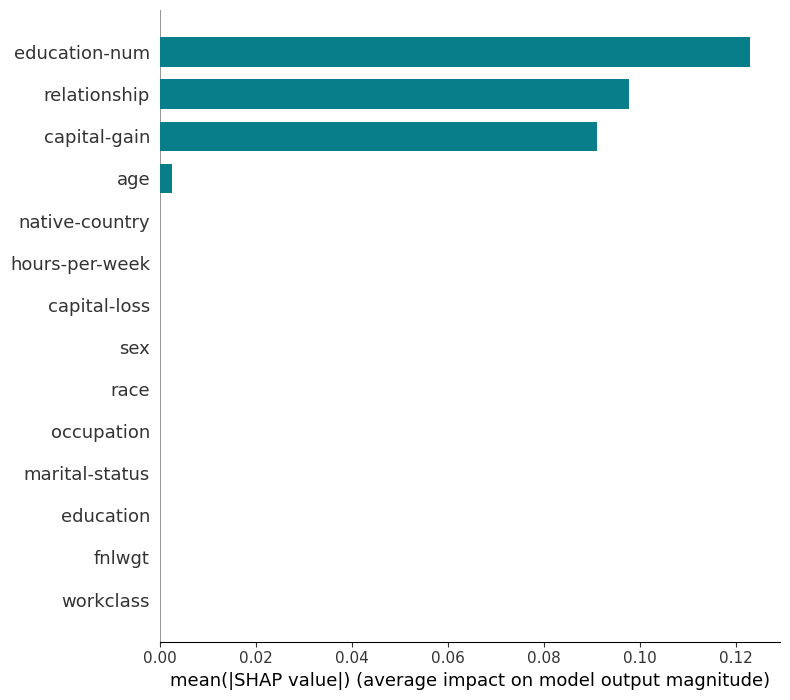

In [51]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

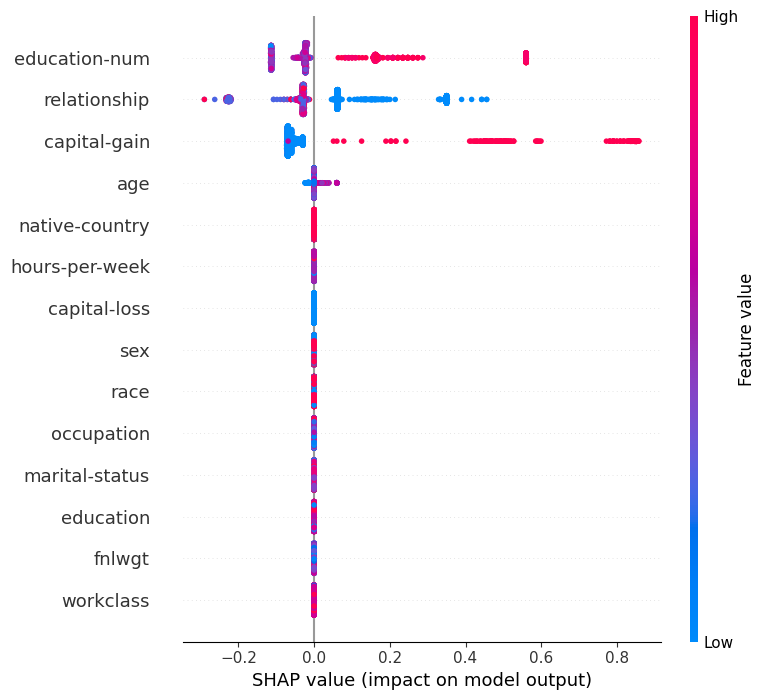

In [52]:
shap.summary_plot(shap_values, X_test)

* Based on the explanation you provided, the output values show the features' impact on the model's prediction, with red dots indicating a positive influence (increasing the prediction) and blue dots indicating a negative influence (decreasing the prediction). The force plot's position showcases how strongly this influence changes with the feature's value.

##REFERENCES:-

* CHATGPT
* https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb

###**LICENSE**

MIT License

Copyright (c) 2024 thoratmansi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.